# CS5660 Final Project
## Topic Modeling on arXiv abstract data
Ryan Dielhenn  
Joe Jimenez  
Bohdan Hrotovytskyy  
Ryan Goshorn  
CalStateLA

## Topic Modeling

### Def 1.
**Topic modeling** is an **unsupervised machine learning technique** that automatically identifies the abstract topics present within a collection of documents. It assumes that each document is a mixture of a small number of topics and that each topic is characterized by a distribution over words. The goal of topic modeling is to uncover the hidden thematic structure in large textual datasets, facilitating tasks such as organization, summarization, and discovery of patterns without prior annotation.

### Def 2.
* The problem of modeling text corpora and other collections of discrete data. The goal is to find short descriptions of the members of a collection that enable efficient processing of large collections while preserving the essential statistical relationships that are useful for basic tasks such as classification, novelty detection, summarization, and similarity and relevance judgments.


[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.


### Traditional Topic Models and Their Limitation

* Traditional Approaches:
    * Latent Dirichlet Allocation (LDA)
    * Non-Negative Matrix Factorization (NMF)

* Bag-of-Words Assumption
    * Treat documents as a collection of individual words (e.g., ignores word order).

* Limitation:
    * Ignores the meaning and relationship between words.

### What is a Bag-of-Words?
* A bag-of-words is a representation of text that describes the occurrence of words within a document.
    
    * A vocabulary
    * A measure of the presence of known words.



# Project: Topic Modeling arXiv cs.AI with BERTopic and LLMs

## Goal
Discover the main research themes in the **cs.AI** category on arXiv by:
- Grouping similar paper abstracts into topics
- Automatically generating human-readable labels for each topic
- Visualizing how topics relate to each other

## Methods (High-Level)
- **Bag-of-Words demo:** Simple example to introduce topic modeling.
- **BERTopic:** Uses sentence embeddings + UMAP + HDBSCAN to create dense, meaningful clusters.
- **LLM labeling (Llama3 via Ollama):** Generates concise, human-style topic names from keywords and representative documents.
- **Visualization:**
  - Intertopic distance maps
  - Topic word score bar charts
  - Document map scatter plots
  - Final radial topic map (DataMapPlot)

## Dataset
- Source: arXiv API, category **cs.AI**
- Data: ~1000 paper abstracts (title + abstract text)
- Use case: Explore what kinds of AI research areas are most common in this category.


In [1]:
from tensorflow import keras
from typing import List
from tensorflow.keras.preprocessing.text import Tokenizer

sentence = ["John likes to watch movies. Mary likes movies too."]


def print_bow(sentence: List[str]) -> None:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    sequences = tokenizer.texts_to_sequences(sentence)
    word_index = tokenizer.word_index
    bow = {}
    for key in word_index:
        bow[key] = sequences[0].count(word_index[key])

    print(f"Bag of word sentence 1:\n{bow}")
    print(f"{word_index}")
    print(f"We found {len(word_index)} unique tokens.")


print_bow(sentence)

Bag of word sentence 1:
{'likes': 2, 'movies': 2, 'john': 1, 'to': 1, 'watch': 1, 'mary': 1, 'too': 1}
{'likes': 1, 'movies': 2, 'john': 3, 'to': 4, 'watch': 5, 'mary': 6, 'too': 7}
We found 7 unique tokens.


In [2]:
print("John likes to watch movies. Mary likes movies too.")

John likes to watch movies. Mary likes movies too.


### BERTopic [(🔗)](https://maartengr.github.io/BERTopic/index.html)
BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

### Visual Overview

BERTopic can be viewed as a sequence of steps to create its topic representations. BERTopic generates topics from text through a four-step process:

1. **Embedding**: Each document is first transformed into a numerical vector using a pre-trained language model such as BERT. This step captures the semantic meaning and contextual nuances of the text.

2. **Dimensionality Reduction**: Because the resulting vectors are high-dimensional, a dimensionality reduction technique (e.g., UMAP) is applied to simplify the representation while preserving important structure, making clustering more efficient and effective.

3. **Clustering**: The reduced vectors are then clustered into groups, where each cluster corresponds to a potential topic.

4. **Topic Representation**: For each cluster, BERTopic applies a technique called class-based TF-IDF to identify the key words that best characterize the topic.

This end-to-end process enables BERTopic to generate clear, interpretable, and contextually rich topics, often outperforming traditional topic modeling methods.


## Install required libraries

In [3]:
# BERTopic library
!pip install -q BERTopic

# Visualization Libraries
!pip install -q datamapplot matplotlib

# Tokenization and ollama for running llm locally
!pip install -q openai tiktoken ollama

## Import required packages

In [3]:
# Core
import os
import sys
import re
import time
import subprocess
import ast
import json

# Data
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# Topic modeling
from bertopic import BERTopic
from bertopic.representation import (
    KeyBERTInspired,
    MaximalMarginalRelevance,
    TextGeneration,
    OpenAI as RepresentationOpenAI
)
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

# Visualization
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import datamapplot

# External services
from openai import OpenAI
import openai

import kagglehub
# Download latest version of dataset from kagglehub
path = kagglehub.dataset_download("Cornell-University/arxiv")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'arxiv' dataset.
Path to dataset files: /kaggle/input/arxiv


## BERTopic Quick Start

### 📄 Loading the Dataset

In [4]:
filepath = os.path.join(path, 'arxiv-metadata-oai-snapshot.json')

docs = []
titles = []
years = []
SAMPLE_SIZE = 5000

with open(filepath, 'r') as f:
    for line in f:
        paper = json.loads(line)
        if 'cs.AI' in paper.get('categories', ''):
            docs.append(paper['abstract'].replace('\n', ' ').strip())
            titles.append(paper['title'].replace('\n', ' ').strip())

print(f"Found {len(docs)} cs.AI papers")
print(f"Sampling {SAMPLE_SIZE} of them")
sample = docs[:SAMPLE_SIZE]


Found 151883 cs.AI papers
Sampling 5000 of them


In [6]:
sample[0]

'The intelligent acoustic emission locator is described in Part I, while Part II discusses blind source separation, time delay estimation and location of two simultaneously active continuous acoustic emission sources.   The location of acoustic emission on complicated aircraft frame structures is a difficult problem of non-destructive testing. This article describes an intelligent acoustic emission source locator. The intelligent locator comprises a sensor antenna and a general regression neural network, which solves the location problem based on learning from examples. Locator performance was tested on different test specimens. Tests have shown that the accuracy of location depends on sound velocity and attenuation in the specimen, the dimensions of the tested area, and the properties of stored data. The location accuracy achieved by the intelligent locator is comparable to that obtained by the conventional triangulation method, while the applicability of the intelligent locator is mo

### Building and Training the BERTopic Model

In [7]:
topic_model = BERTopic(nr_topics=20)
topics, probs = topic_model.fit_transform(sample)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

After generating topics and their probabilities, we can access the frequent topics that were generated:

In [8]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1849,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, this]","[Within the framework proposed in this paper, ..."
1,0,691,0_of_the_and_in,"[of, the, and, in, to, is, we, for, that, logic]","[Probability theory, epistemically interpreted..."
2,1,514,1_the_of_to_in,"[the, of, to, in, we, and, that, planning, for...",[This paper addresses the problem of planning ...
3,2,401,2_the_of_networks_in,"[the, of, networks, in, for, and, we, to, that...",[Structure and parameters in a Bayesian networ...
4,3,205,3_the_of_to_and,"[the, of, to, and, in, algorithm, is, optimiza...",[In recent years genetic algorithms have emerg...
5,4,194,4_fuzzy_the_rough_of,"[fuzzy, the, rough, of, and, in, is, sets, to,...",[The introduction of covering-based rough sets...
6,5,168,5_the_of_learning_to,"[the, of, learning, to, we, and, in, that, for...",[One of the objectives of designing feature se...
7,6,162,6_the_of_and_in,"[the, of, and, in, to, mining, data, is, we, p...",[The use of patterns in predictive models is a...
8,7,155,7_of_the_and_intelligence,"[of, the, and, intelligence, to, in, is, that,...",[The main purpose of this article is to descri...
9,8,134,8_web_semantic_the_of,"[web, semantic, the, of, and, ontology, data, ...",[The emerging Web of Data utilizes the web inf...


* -1 refers to all outliers and should typically be ignored.
* Next, let's take a look at the most frequent topic that was generated, topic 0:

In [9]:
topic_model.get_topic(0)

[('of', np.float64(0.03602592742623172)),
 ('the', np.float64(0.03384312551329867)),
 ('and', np.float64(0.02797196583857783)),
 ('in', np.float64(0.026623822735760902)),
 ('to', np.float64(0.02650145493956994)),
 ('is', np.float64(0.02468558839081746)),
 ('we', np.float64(0.023576100959955392)),
 ('for', np.float64(0.0232402089022473)),
 ('that', np.float64(0.02160669150018329)),
 ('logic', np.float64(0.02093148430269814))]

Using `.get_document_info`, we can also extract information on a document level, such as their corresponding topics, probabilities, whether they are representative documents for a topic


In [10]:
topic_model.get_document_info(sample)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,The intelligent acoustic emission locator is d...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, this]","[Within the framework proposed in this paper, ...",the - of - and - to - in - we - is - for - tha...,0.000000,False
1,Part I describes an intelligent acoustic emiss...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, this]","[Within the framework proposed in this paper, ...",the - of - and - to - in - we - is - for - tha...,0.000000,False
2,This paper discusses the benefits of describin...,7,7_of_the_and_intelligence,"[of, the, and, intelligence, to, in, is, that,...",[The main purpose of this article is to descri...,of - the - and - intelligence - to - in - is -...,0.985013,False
3,Advances in semiconductor technology are contr...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, this]","[Within the framework proposed in this paper, ...",the - of - and - to - in - we - is - for - tha...,0.000000,False
4,Ordinal regression is an important type of lea...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, this]","[Within the framework proposed in this paper, ...",the - of - and - to - in - we - is - for - tha...,0.000000,False
...,...,...,...,...,...,...,...,...
4995,The need for efficient monitoring of spatio-te...,1,1_the_of_to_in,"[the, of, to, in, we, and, that, planning, for...",[This paper addresses the problem of planning ...,the - of - to - in - we - and - that - plannin...,0.584229,False
4996,"In the last two decades, modal and description...",0,0_of_the_and_in,"[of, the, and, in, to, is, we, for, that, logic]","[Probability theory, epistemically interpreted...",of - the - and - in - to - is - we - for - tha...,0.968930,False
4997,Bayesian networks are a useful tool in the rep...,2,2_the_of_networks_in,"[the, of, networks, in, for, and, we, to, that...",[Structure and parameters in a Bayesian networ...,the - of - networks - in - for - and - we - to...,1.000000,False
4998,Coalition formation is a fundamental type of i...,1,1_the_of_to_in,"[the, of, to, in, we, and, that, planning, for...",[This paper addresses the problem of planning ...,the - of - to - in - we - and - that - plannin...,0.796104,True


 ### Representation Models: Fine-tune Topic Representation

BERTopic uses a Bag-of-Words approach with class-based TF-IDF (c-TF-IDF) to quickly generate topic keywords without needing to re-train the model after clustering.
While this provides good initial topic representations, BERTopic also offers optional representation models for further fine-tuning.
These models can range from powerful GPT-like models to faster keyword extraction methods like KeyBERT, giving users flexibility to enhance topic quality as needed.

### LLM & Generative AI

Using LLMs such as GPT-4, and open source soultion, we can fine-tune topics to generate labels, summaries of the topics.

- Generate a set of keywords and documetns that describe a topic best using BERTopic's c-TF-IDF .
- Candidate keywords and documents are passed to the text generation model and asked to generate output that fits the topic best.


#### Prompt


In [11]:
prompt = """
I have topic that contains the following documents: \n[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the above information, can you give a short label of the topic?
"""

### Selecting Documents

Four of the most representative documents will be passed to `[Documents]`.


BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>


In [6]:
!curl -fsSL https://ollama.ai/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [63]:
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

def run_ollama_serve():
    subprocess.Popen(["nohup", "ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

run_ollama_serve()
time.sleep(5)
print("Ollama server started.")

Ollama server started.


In [33]:
!ollama pull llama3

In [34]:
# Configure the client to use the local Ollama server
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama', # dummy API key required by the client library
)

# Use the model you pulled (e.g., "llama3")
model_name = "llama3"

print(f"Sending request to {model_name}...")

# Example using the standard OpenAI client chat completion
try:
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "user", "content": "Explain how to run an LLM locally in one sentence."}
        ],
        temperature=0.7,
    )
    print("\n--- Model Response ---")
    print(response.choices[0].message.content)
    print("----------------------")

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("Make sure the 'ollama serve' process is running in the background.")

# You can run !ollama ps again after this code executes to see the model usage
time.sleep(2)
!ollama ps

Sending request to llama3...

--- Model Response ---
To run a large language model (LLM) locally, you can install the Hugging Face Transformers library and use the `transformers.Llama` module to load the pre-trained model weights, then fine-tune it on your own dataset or use it for inference tasks using Python code.
----------------------
NAME             ID              SIZE      PROCESSOR    CONTEXT    UNTIL              
llama3:latest    365c0bd3c000    5.2 GB    100% GPU     4096       4 minutes from now    


In [35]:
!curl http://localhost:11434/

Ollama is running

In [18]:
# Assuming bertopic and its dependencies are installed
# If not, run this line first: !pip install bertopic sentence-transformers

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Generate a concise topic label (3-7 words) that captures the main theme.

CRITICAL INSTRUCTIONS:
- Output ONLY the topic label itself
- Do NOT include phrases like "Here is", "The topic is", "Topic:", or any preamble
- Do NOT add explanations or formatting
- Just output the label directly as plain text

Example output: "Neural Networks for Computer Vision"

Your label:"""

# Configure the client to use the local Ollama server
client = openai.OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama_key_placeholder",
)

# Use the model you pulled (e.g., "llama3")
OLLAMA_MODEL_NAME = "llama3"
ollama_representation_model = RepresentationOpenAI(client, prompt=prompt, model=OLLAMA_MODEL_NAME, delay_in_seconds=10)

print(f"Representation model configured using local Ollama model: {OLLAMA_MODEL_NAME}")

# You can now proceed with your BERTopic workflow:
# topic_model = BERTopic(representation_model=representation_model)
# documents = [...] # Your actual list of documents
# topics, probabilites = topic_model.fit_transform(documents)

# Verification using a simple prompt
try:
    response = client.chat.completions.create(
        model=OLLAMA_MODEL_NAME,
        messages=[
            {"role": "user", "content": "Confirm that you are running locally via Ollama."}
        ],
    )
    print("\n--- Verification Response ---")
    print(response.choices[0].message.content)
    print("-----------------------------")
except Exception as e:
    print(f"\nAn error occurred during verification: {e}")

Representation model configured using local Ollama model: llama3

An error occurred during verification: Connection error.


## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

**TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [56]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("Qwen/Qwen3-Embedding-8B")
embeddings = embedding_model.encode(sample, show_progress_bar=True)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [57]:
#Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [58]:
df_plot = pd.DataFrame({
    "x1": [point[0] for point in reduced_embeddings],
    "x2": [point[1] for point in reduced_embeddings],
    "sample": sample,
})

df_plot["sample_short"] = df_plot["sample"].str[:100] + "..."
df_plot.head(10)

,x1,x2,sample,sample_short
0,10.146516,-0.754852,The intelligent acoustic emission locator is d...,The intelligent acoustic emission locator is d...
1,10.330728,-0.719824,Part I describes an intelligent acoustic emiss...,Part I describes an intelligent acoustic emiss...
2,8.573460,2.024554,This paper discusses the benefits of describin...,This paper discusses the benefits of describin...
3,8.952456,2.350588,Advances in semiconductor technology are contr...,Advances in semiconductor technology are contr...
4,11.990565,-0.838597,Ordinal regression is an important type of lea...,Ordinal regression is an important type of lea...
5,6.896072,-4.724570,In these notes we formally describe the functi...,In these notes we formally describe the functi...
6,4.508337,-0.742379,This paper has been withdrawn by the author. T...,This paper has been withdrawn by the author. T...
7,10.527250,-1.702921,"Information integration applications, such as ...","Information integration applications, such as ..."
8,10.587089,-1.723946,The social media site Flickr allows users to u...,The social media site Flickr allows users to u...
9,11.685568,2.153702,We present a formal model to represent and sol...,We present a formal model to represent and sol...


In [59]:
pio.renderers.default = "colab"

total_docs = len(df_plot)
fig = px.scatter(df_plot, x="x1", y="x2",  hover_data=["sample_short"])
fig.update_traces(marker=dict(line=dict(width=0.5, color='white')))
fig.update_layout(
    title=f"arXiv abstracts from cs.AI - Document Map ({total_docs} documents)",
    title_font_size=20
)

fig.show()

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [60]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [61]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
#llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "GPT-40": ollama_representation_model, # Use the renamed object
    "MMR": mmr,
}

# **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

## Multiple Representations
During the development of BERTopic, many different types of representations can be created, from keywords and phrases to summaries and custom labels. There is a variety of techniques that one can choose from to represent a topic. As such, there are a number of interesting and creative ways one can summarize topics. A topic is more than just a single representation.

Therefore, multi-aspect topic modeling is introduced! During the .fit or .fit_transform stages, you can now get multiple representations of a single topic. In practice, it works by generating and storing all kinds of different topic representations (see image below).


In [64]:
# To remove English stopwords
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
  nr_topics=20,
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(sample, embeddings)

2025-11-26 20:55:08,764 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-26 20:55:22,344 - BERTopic - Dimensionality - Completed ✓
2025-11-26 20:55:22,345 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-26 20:55:22,537 - BERTopic - Cluster - Completed ✓
2025-11-26 20:55:22,538 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-26 20:55:23,029 - BERTopic - Representation - Completed ✓
2025-11-26 20:55:23,030 - BERTopic - Topic reduction - Reducing number of topics
2025-11-26 20:55:23,040 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 20/20 [03:33<00:00, 10.66s/it]
2025-11-26 20:59:34,627 - BERTopic - Representation - Completed ✓
2025-11-26 20:59:34,630 - BERTopic - Topic reduction - Reduced number of topics from 62 to 20


Now that we are done training our model, let's see what topics were generated:


In [65]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,GPT-40,MMR,Representative_Docs
0,-1,1688,-1_based_model_paper_knowledge,"[based, model, paper, knowledge, problem, algo...","[probabilistic, approaches, complexity, uncert...",[Coalitional Learning in Multi-Agent Systems],"[model, paper, algorithm, approach, systems, p...",[We propose a new approach for solving a class...
1,0,1339,0_algorithm_learning_algorithms_problem,"[algorithm, learning, algorithms, problem, pla...","[bayesian, probabilistic, heuristic, inference...",[Bayesian Network Algorithms],"[learning, algorithms, planning, model, infere...",[In recent years there has been a flurry of wo...
2,1,392,1_constraint_sat_constraints_asp,"[constraint, sat, constraints, asp, answer, pr...","[csps, satisfiability, maxsat, solvers, solver...",[Constraint Satisfaction and Boolean Logic],"[constraints, programs, logic, solvers, symmet...",[Code optimization and high level synthesis ca...
3,2,363,2_web_semantic_ontology_data,"[web, semantic, ontology, data, ontologies, la...","[ontologies, ontology, semantics, rdf, semanti...",[Semantic Web Development],"[ontology, data, ontologies, description, sema...",[One of the key challenges in electronic gover...
4,3,217,3_belief_theory_probability_utility,"[belief, theory, probability, utility, dempste...","[probabilistic, evidential, possibilistic, bay...",[Uncertain Reasoning and Probability Theory],"[theory, utility, dempster, uncertainty, possi...",[While belief functions may be seen formally a...
5,4,172,4_optimization_search_problem_algorithm,"[optimization, search, problem, algorithm, pro...","[metaheuristics, metaheuristic, heuristics, ps...","[""Combinatorial Optimization and Intelligent S...","[optimization, problems, algorithms, evolution...","[This paper introduces Gene-Machine, an effici..."
6,5,151,5_intelligence_information_human_artificial,"[intelligence, information, human, artificial,...","[intelligence, ai, turing, artificial, complex...","[""Intelligent Information Compression Theory""]","[intelligence, artificial, turing, cognitive, ...",[This paper provides an overview of the SP the...
7,6,147,6_diagnosis_fuzzy_based_model,"[diagnosis, fuzzy, based, model, diagnostic, d...","[diagnostic, diagnosis, diagnoses, fuzzy, clin...",[Diagnosis and Decision-Making Systems],"[diagnosis, fuzzy, model, diagnostic, decision...",[Medical diagnosis process involves many level...
8,7,142,7_game_games_market_agents,"[game, games, market, agents, players, player,...","[minimax, payoffs, game, equilibria, agents, n...",[Game Theory and Equilibrium Strategies],"[game, market, agents, strategies, nash, equil...",[This paper discusses an interested party who ...
9,8,89,8_immune_detection_intrusion_dca,"[immune, detection, intrusion, dca, systems, a...","[immunity, immunological, immune, immunology, ...",[Artificial Immune Systems for Security],"[detection, intrusion, dca, systems, algorithm...",[Artificial immune systems have previously bee...


In [66]:
print(f"Renderer set to '{pio.renderers.default}'")
fig = topic_model.visualize_topics()
fig.show()

Renderer set to 'colab'


In [67]:
gpt4o_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["GPT-40"].values()]

In [68]:
def get_clean_label(raw_label_string):
    """Extracts clean label from list or string."""
    # If it's already a list, just take the first element
    if isinstance(raw_label_string, list):
        return raw_label_string[0] if raw_label_string else "Unlabeled Topic"

    # If it's a string, clean it up
    if isinstance(raw_label_string, str):
        cleaned = raw_label_string.strip()
        # Remove brackets and quotes if present
        cleaned = cleaned.strip("[]").strip().strip("'\"").strip()
        return cleaned if cleaned else "Unlabeled Topic"

    # Fallback for other types
    return str(raw_label_string)

In [69]:
# Get document info
document_info = topic_model.get_document_info(sample)
document_info["GPT-40"] = document_info["GPT-40"]

In [70]:
# First, let's inspect the raw content of the 'GPT-40' column
print("--- Raw GPT-40 labels (before cleaning) ---")
display(document_info["GPT-40"].head())

# Now, apply the cleaning function
all_labels = document_info["GPT-40"].apply(get_clean_label)

print("\n--- Cleaned Labels (after cleaning) ---")
display(all_labels.head())

--- Raw GPT-40 labels (before cleaning) ---


,GPT-40
0,[Coalitional Learning in Multi-Agent Systems]
1,[Coalitional Learning in Multi-Agent Systems]
2,"[""Intelligent Information Compression Theory""]"
3,[Coalitional Learning in Multi-Agent Systems]
4,[Bayesian Network Algorithms]



--- Cleaned Labels (after cleaning) ---


,GPT-40
0,Coalitional Learning in Multi-Agent Systems
1,Coalitional Learning in Multi-Agent Systems
2,"""Intelligent Information Compression Theory"""
3,Coalitional Learning in Multi-Agent Systems
4,Bayesian Network Algorithms


In [71]:
fig = topic_model.visualize_barchart()
fig.show()

# Visualize Documents


In [72]:
df_plot = pd.DataFrame({
    "x1": [point[0] for point in reduced_embeddings],
    "x2": [point[1] for point in reduced_embeddings],
    "sample": sample,
    "label": all_labels
})
df_plot["sample_short"] = df_plot["sample"].str[:100] + "..."
df_plot.head(10)

,x1,x2,sample,label,sample_short
0,10.146516,-0.754852,The intelligent acoustic emission locator is d...,Coalitional Learning in Multi-Agent Systems,The intelligent acoustic emission locator is d...
1,10.330728,-0.719824,Part I describes an intelligent acoustic emiss...,Coalitional Learning in Multi-Agent Systems,Part I describes an intelligent acoustic emiss...
2,8.573460,2.024554,This paper discusses the benefits of describin...,"""Intelligent Information Compression Theory""",This paper discusses the benefits of describin...
3,8.952456,2.350588,Advances in semiconductor technology are contr...,Coalitional Learning in Multi-Agent Systems,Advances in semiconductor technology are contr...
4,11.990565,-0.838597,Ordinal regression is an important type of lea...,Bayesian Network Algorithms,Ordinal regression is an important type of lea...
5,6.896072,-4.724570,In these notes we formally describe the functi...,Coalitional Learning in Multi-Agent Systems,In these notes we formally describe the functi...
6,4.508337,-0.742379,This paper has been withdrawn by the author. T...,Coalitional Learning in Multi-Agent Systems,This paper has been withdrawn by the author. T...
7,10.527250,-1.702921,"Information integration applications, such as ...",Semantic Web Development,"Information integration applications, such as ..."
8,10.587089,-1.723946,The social media site Flickr allows users to u...,Semantic Web Development,The social media site Flickr allows users to u...
9,11.685568,2.153702,We present a formal model to represent and sol...,Wireless Network Routing Optimization Strategies,We present a formal model to represent and sol...


In [73]:
fig = px.scatter(df_plot, x="x1", y="x2", color="label", hover_data=["sample_short"])

fig.update_layout(
    height=600,
    legend=dict(
        orientation="h",  # Change orientation to horizontal
        yanchor="bottom",
        y=1.02,           # Place the legend above the plot area
        xanchor="right",
        x=1
    )
)

fig.show()

Source: https://www.williampnicholson.com/2024-02-07-topic-modelling/

Calculating medoids: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


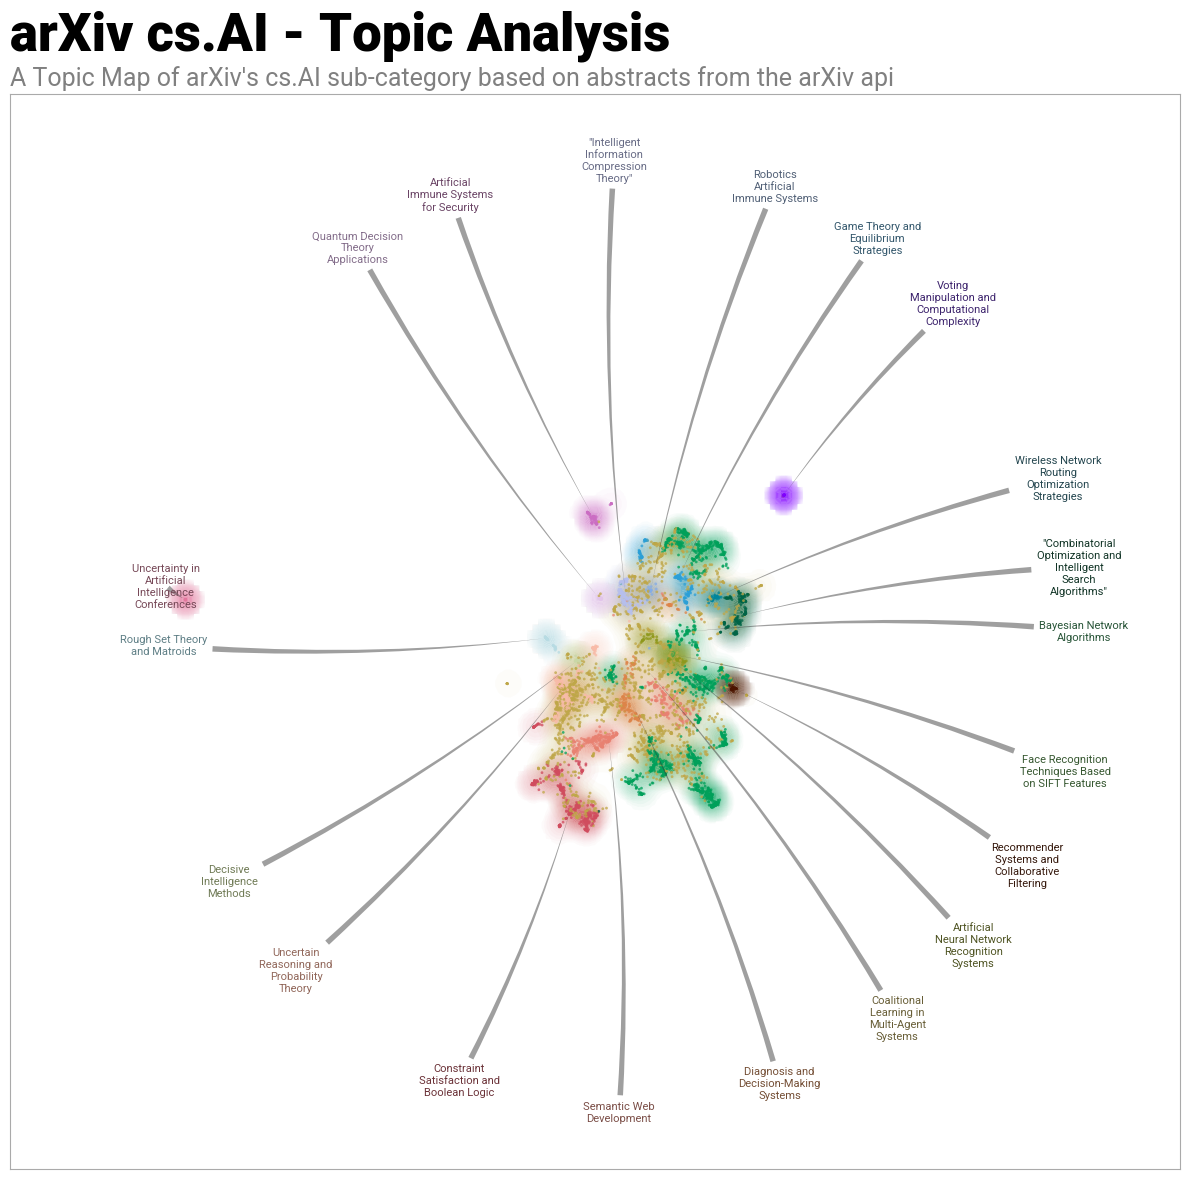

In [74]:
# Run the topic map visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,

    use_medoids=True,

    # Follows matplotlib’s 'figsize' convention.
    # The actual size of the resulting plot (in pixels) will depend on the dots per inch (DPI)
    # setting in matplotlib.
    # By default that is set to 100 dots per inch for the standard backend, but it can vary.
    figsize=(12, 12),
    # If you really wish to have explicit control of the size of the resulting plot in pixels.
    dpi=100,

    title="arXiv cs.AI - Topic Analysis",
    sub_title="A Topic Map of arXiv's cs.AI sub-category based on abstracts from the arXiv api",

    # Takes a dictionary of keyword arguments that is passed through to
    # matplotlib’s 'suptitle' 'fontdict' arguments.
    sub_title_keywords={
        "fontsize":18,
    },

    # Takes a list of text labels to be highlighted.
    # Note: these labels need to match the exact text from your labels array that you are passing in.
    highlight_labels=[
        "Retinopathy Prematurity Screening",
    ],
    # Takes a dictionary of keyword arguments to be applied when styling the labels.
    highlight_label_keywords={
        "fontsize": 12,
        "fontweight": "bold",
        "bbox": {"boxstyle":"round"}
    },

    # By default DataMapPlot tries to automatically choose a size for the text that will allow
    # all the labels to be laid out well with no overlapping text. The layout algorithm will try
    # to accommodate the size of the text you specify here.
    label_font_size=8,
    label_wrap_width=16,
    label_linespacing=1.25,
    # Default is 1.5. Generally, the values of 1.0 and 2.0 are the extremes.
    # With 1.0 you will have more labels at the top and bottom.
    # With 2.0 you will have more labels on the left and right.
    label_direction_bias=1.3,
    # Controls how large the margin is around the exact bounding box of a label, which is the
    # bounding box used by the algorithm for collision/overlap detection.
    # The default is 1.0, which means the margin is the same size as the label itself.
    # Generally, the fewer labels you have the larger you can make the margin.
    label_margin_factor=2.0,
    # Labels are placed in rings around the core data map. This controls the starting radius for
    # the first ring. Note: you need to provide a radius in data coordinates from the center of the
    # data map.
    # The defaul is selected from the data itself, based on the distance from the center of the
    # most outlying points. Experiment and let the DataMapPlot algoritm try to clean it up.
    label_base_radius=15.0,

    # By default anything over 100,000 points uses datashader to create the scatterplot, while
    # plots with fewer points use matplotlib’s scatterplot.
    # If DataMapPlot is using datashader then the point-size should be an integer,
    # say 0, 1, 2, and possibly 3 at most. If however you are matplotlib scatterplot mode then you
    # have a lot more flexibility in the point-size you can use - and in general larger values will
    # be required. Experiment and see what works best.
    point_size=4,

    # Market type. There is only support if you are in matplotlib's scatterplot mode.
    # https://matplotlib.org/stable/api/markers_api.html
    marker_type="o",

    arrowprops={
        "arrowstyle":"wedge,tail_width=0.5",
        "connectionstyle":"arc3,rad=0.05",
        "linewidth":0,
        "fc":"#33333377"
    },

    add_glow=True,
    # Takes a dictionary of keywords that are passed to the 'add_glow_to_scatterplot' function.
    glow_keywords={
        "kernel_bandwidth": 0.75,  # controls how wide the glow spreads.
        "kernel": "cosine",        # controls the kernel type. Default is "gaussian". See https://scikit-learn.org/stable/modules/density.html#kernel-density.
        "n_levels": 32,            # controls how many "levels" there are in the contour plot.
        "max_alpha": 0.9,          # controls the translucency of the glow.
    },

    darkmode=False,
)

plt.tight_layout()

# Save the plot as a PDF, png, and svg file.
plt.show()